In [1]:
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

%matplotlib inline

Using TensorFlow backend.


In [2]:
# re-size all the images to this
IMAGE_SIZE = [200, 200] # feel free to change depending on dataset

# training config:
epochs = 5
batch_size = 32

In [3]:
train_path = '../input/fruits-360-small/Training'
valid_path = '../input/fruits-360-small/Validation'

# getting files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

# getting all classes
folders = glob(train_path + '/*')

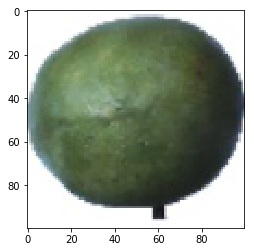

In [4]:
# look at an image for fun
plt.imshow(image.load_img(np.random.choice(image_files)))

In [5]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [6]:
# don't train existing weights, we could tho, this will lead to better result, more computational time
for layer in vgg.layers:
    layer.trainable = False

In [7]:
# our layers with fruits 360 data
x = Flatten()(vgg.output)
# x = Dense(1000, activation = 'relu')(x)
# x = Dense(1000, activation = 'relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [8]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

In [10]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [11]:
# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)


In [12]:
# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

Found 1289 images belonging to 8 classes.
{'Apple Golden 1': 0, 'Avocado': 1, 'Banana': 2, 'Kiwi': 3, 'Lemon': 4, 'Mango': 5, 'Raspberry': 6, 'Strawberry': 7}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -97.939 max: 151.061


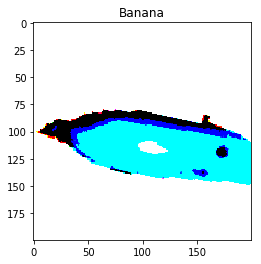

In [13]:
# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
    print("min:", x[0].min(), "max:", x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    break

#   preprocessing_function=preprocess_input

In [14]:
# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 3839 images belonging to 8 classes.
Found 1289 images belonging to 8 classes.


In [15]:
# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

Epoch 1/5
119/119 [==============================] - 952s 8s/step - loss: 2.1407 - acc: 0.8566 - val_loss: 1.8381 - val_acc: 0.8844
Epoch 2/5
119/119 [==============================] - 954s 8s/step - loss: 1.8081 - acc: 0.8868 - val_loss: 1.8482 - val_acc: 0.8829
Epoch 3/5
119/119 [==============================] - 955s 8s/step - loss: 1.8166 - acc: 0.8873 - val_loss: 1.8043 - val_acc: 0.8875
Epoch 4/5
119/119 [==============================] - 954s 8s/step - loss: 1.7903 - acc: 0.8889 - val_loss: 1.8802 - val_acc: 0.8798
Epoch 5/5
119/119 [==============================] - 955s 8s/step - loss: 1.9273 - acc: 0.8773 - val_loss: 1.8188 - val_acc: 0.8867


In [16]:
def get_confusion_matrix(data_path, N):
    # we need to see the data in the same order
    # for both predictions and targets
    print("Generating confusion matrix", N)
    predictions = []
    targets = []
    i = 0
    for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
        i+=1
        if i % 50 == 0:
              print(i)
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break

    cm = confusion_matrix(targets, predictions)
    return cm

In [17]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 3839
Found 3839 images belonging to 8 classes.
50
[[492   0   0   0   0   0   0   0]
 [  0   0   8  56   0 319  14  30]
 [  0   0 490   0   0   0   0   0]
 [  2   0   0 464   0   0   0   0]
 [  0   0   0   0 492   0   0   0]
 [  0   0   0   0   0 490   0   0]
 [  0   0   0   0   0   0 490   0]
 [  1   0   0   0   0   0   0 491]]
Generating confusion matrix 1289
Found 1289 images belonging to 8 classes.
[[164   0   0   0   0   0   0   0]
 [  0   0   2   7   0 126   3   5]
 [  0   0 166   0   0   0   0   0]
 [  0   0   0 156   0   0   0   0]
 [  0   0   0   0 164   0   0   0]
 [  0   0   0   0   0 166   0   0]
 [  0   0   0   0   0   0 166   0]
 [  0   0   0   0   0   0   0 164]]


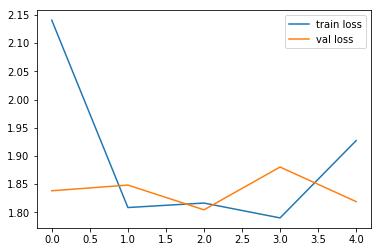

In [18]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

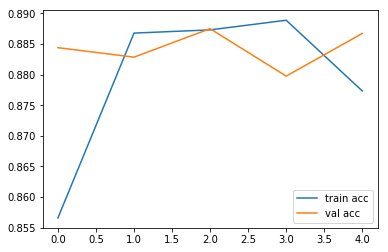

In [19]:
# accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()

In [20]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.figure(figsize=(24,24))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix, without normalization
[[492   0   0   0   0   0   0   0]
 [  0   0   8  56   0 319  14  30]
 [  0   0 490   0   0   0   0   0]
 [  2   0   0 464   0   0   0   0]
 [  0   0   0   0 492   0   0   0]
 [  0   0   0   0   0 490   0   0]
 [  0   0   0   0   0   0 490   0]
 [  1   0   0   0   0   0   0 491]]


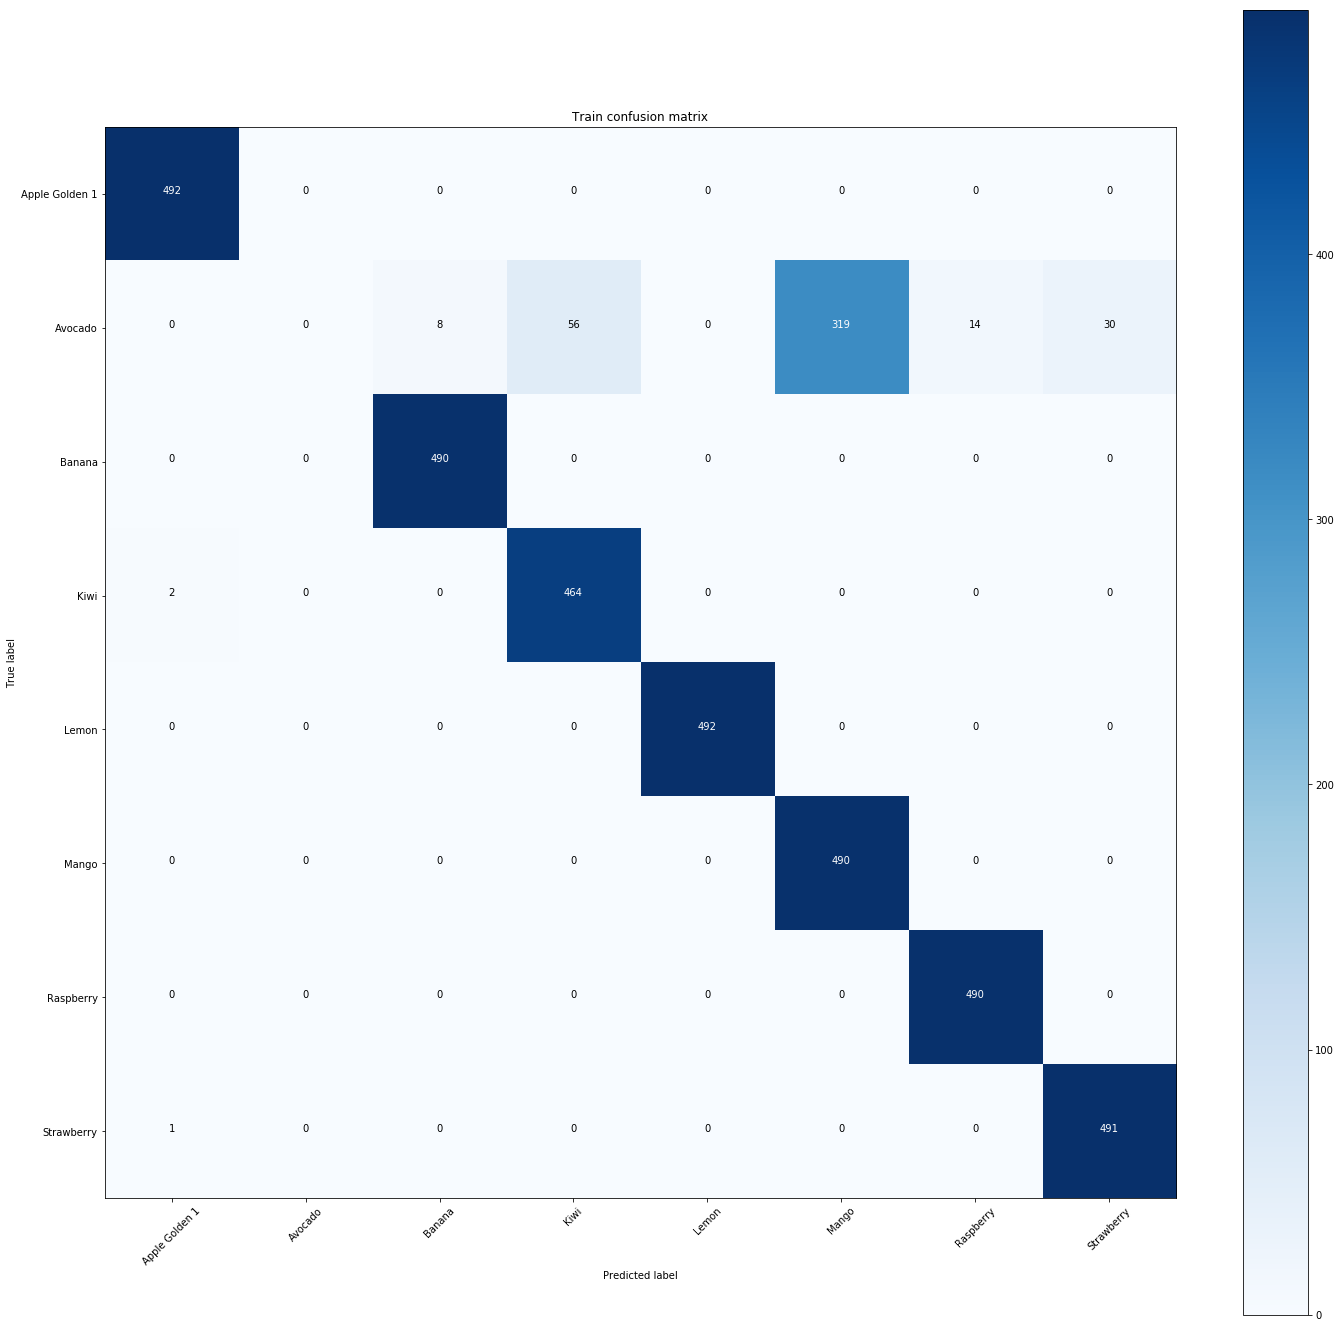

Confusion matrix, without normalization
[[164   0   0   0   0   0   0   0]
 [  0   0   2   7   0 126   3   5]
 [  0   0 166   0   0   0   0   0]
 [  0   0   0 156   0   0   0   0]
 [  0   0   0   0 164   0   0   0]
 [  0   0   0   0   0 166   0   0]
 [  0   0   0   0   0   0 166   0]
 [  0   0   0   0   0   0   0 164]]


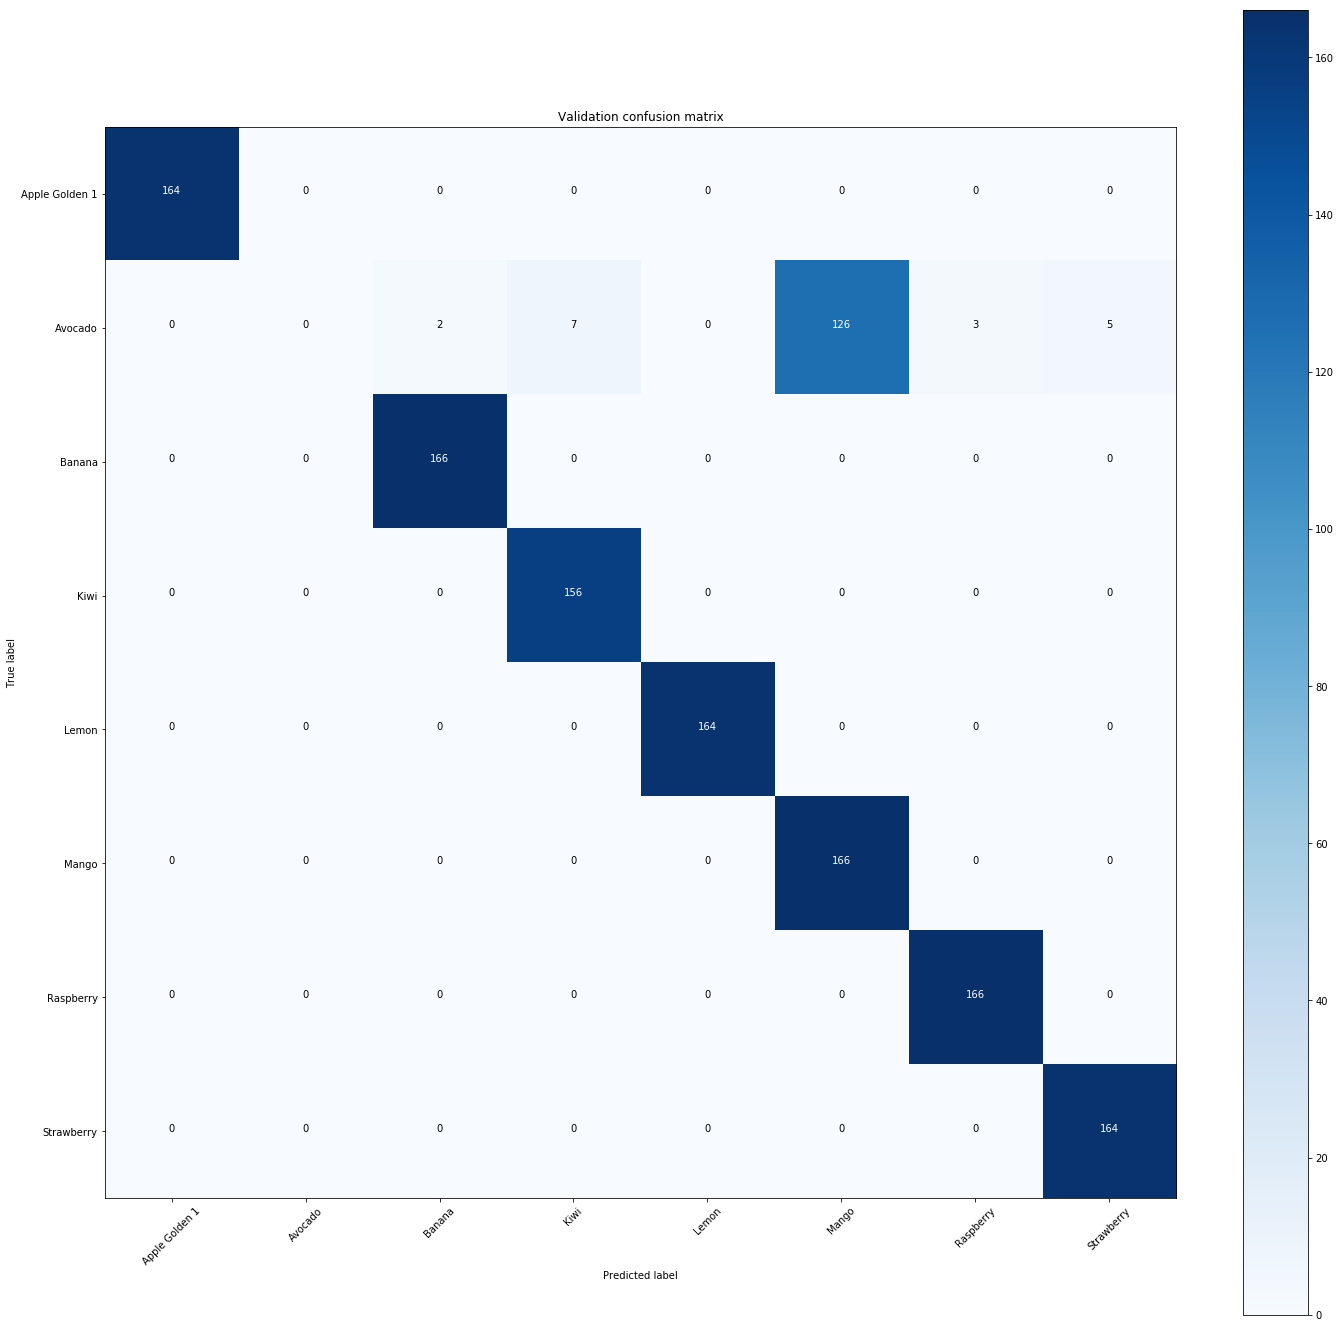

In [21]:
plot_confusion_matrix(cm, labels, title='Train confusion matrix')
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')